In [8]:
import pandas as pd
import numpy  as np
from sqlalchemy import create_engine 
import  seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt

In [9]:
from sqlalchemy import create_engine
engine = create_engine(r'sqlite:///C:\Users\zig53\vscode_jupyther\Algo_Trading\Data Scape\binance_futures.db')

data_3 = pd.read_sql( "SELECT * FROM BTCUSDT_1d "  ,  engine  )

data_3['datetime']  = pd.to_datetime( data_3['datetime'])#.dt.tz_convert('Etc/GMT+0')   #+ timedelta( hours = 14)#.dt.strftime('%Y-%m-%dT%H:%M:%S')
data_3 = data_3.sort_values('datetime').set_index('datetime')

In [10]:
data_3['return'] = data_3['close'].pct_change()

C:\Users\zig53\AppData\Local\Temp\ipykernel_32672\177721338.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( data_3['return'] )


<AxesSubplot:xlabel='return', ylabel='Density'>

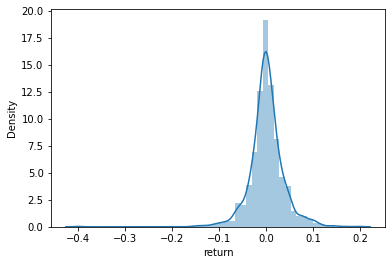

In [11]:
sns.distplot( data_3['return'] )

<AxesSubplot:xlabel='datetime', ylabel='close'>

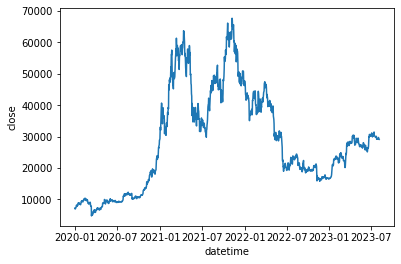

In [12]:
sns.lineplot( data_3['close'] )

Monte Carlo

In [13]:
mu = data_3['return'].mean()
sigma = data_3['return'].std()

sim =  np.random.normal( loc = mu, scale = sigma , size = (365,10000)   ) #(x,y) trade x times  , y scenario
sim =  pd.DataFrame(sim)
sim.iloc[ 0 , : ] = 0

last_day  = (sim+1).cumprod().iloc[-1]

In [14]:
init_cash = 10000
start_price = last_day * init_cash
start_price

0        6518.273651
1       10206.741112
2        7025.037278
3       19482.938640
4       17286.660131
            ...     
9995    16466.777314
9996     5794.107632
9997     7368.594153
9998    13811.259041
9999    24405.303008
Name: 364, Length: 10000, dtype: float64

In [15]:
returns_sim = (sim+1).cumprod()
# plt.plot(returns_sim)
# plt.title( 'Strategy projection', size = 10 )
# plt.xlabel(  'N Trades' , size = 10 )
# plt.ylabel( 'Cum Return' , size  = 10 )
# plt.show();

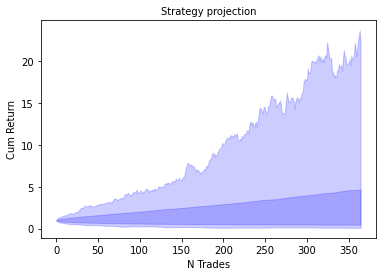

In [16]:
returns_sim['percentile_5'] = np.percentile( returns_sim , 5 , axis = 1 )
returns_sim['percentile_95'] = np.percentile( returns_sim , 95 , axis = 1 )
returns_sim['min'] = np.min( returns_sim , axis = 1 )
returns_sim['max'] = np.max( returns_sim , axis = 1 )

plt.fill_between( returns_sim.index  , returns_sim['percentile_5'] ,  returns_sim['percentile_95'] , color = 'blue' , alpha = 0.2   )
plt.fill_between( returns_sim.index  , returns_sim['min'] ,  returns_sim['max'] , color = 'blue' , alpha = 0.2   )
plt.title( 'Strategy projection', size = 10 )
plt.xlabel(  'N Trades' , size = 10 )
plt.ylabel( 'Cum Return' , size  = 10 )
plt.show()


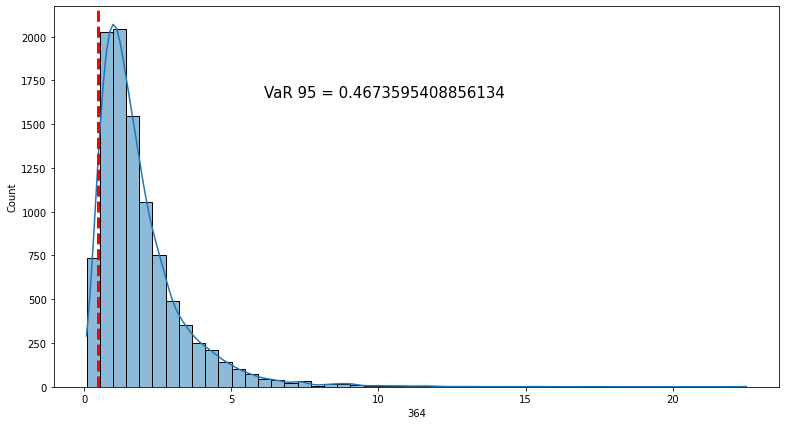

In [17]:
var_95 = np.percentile( returns_sim.iloc[ -1 , :] , 5  )
plt.figure( figsize = (13,7))
sns.histplot( returns_sim.iloc[-1 , :] , bins = 50 , kde = True )
plt.axvline( var_95 ,  linewidth = 3 , color =  'r' , linestyle = "--")
plt.figtext( 0.35 , 0.7 , f"VaR 95 = {var_95}" , fontsize=15);

In [18]:
returns_sim_2 = returns_sim[['percentile_5'	, 'percentile_95'	, 'min'	,'max']]

In [19]:
returns_sim_2

,percentile_5,percentile_95,min,max
0,1.000000,1.000000,1.000000,1.000000
1,0.941464,1.062480,0.826940,1.138862
2,0.919262,1.090838,0.831743,1.223639
3,0.901806,1.114156,0.787849,1.351314
4,0.890220,1.132922,0.734216,1.308152
...,...,...,...,...
360,0.467502,4.639310,0.091660,21.462738
361,0.469112,4.663164,0.081346,22.554200
362,0.463672,4.648510,0.080014,23.066294
363,0.464060,4.667571,0.080214,23.730829


In [20]:
strat_cum_ret = ( data_3['return'] + 1 ).cumprod()
cone  =  pd.concat( [strat_cum_ret , returns_sim_2 * strat_cum_ret.iloc[-1]] , ignore_index = True   )
cone

,0,percentile_5,percentile_95,min,max
0,NaN,NaN,NaN,NaN,NaN
1,1.001192,NaN,NaN,NaN,NaN
2,0.968430,NaN,NaN,NaN,NaN
3,1.021244,NaN,NaN,NaN,NaN
4,1.022494,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1673,NaN,1.892448,18.779944,0.371041,86.881247
1674,NaN,1.898967,18.876504,0.329289,91.299488
1675,NaN,1.876944,18.817187,0.323897,93.372447
1676,NaN,1.878517,18.894345,0.324707,96.062486


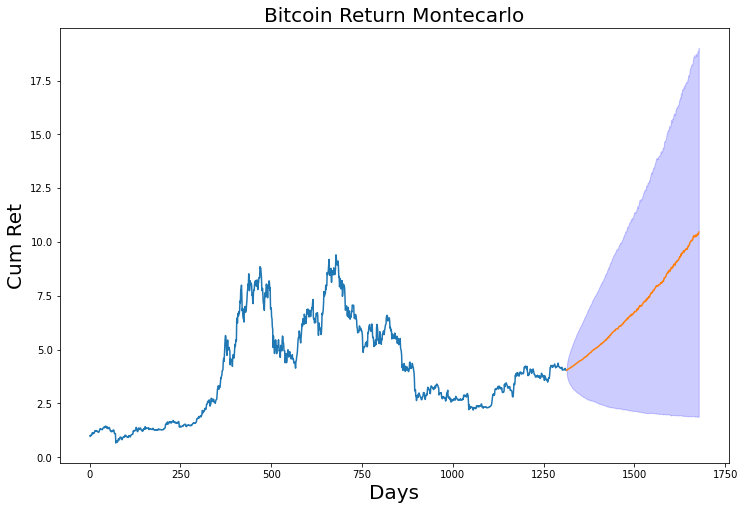

In [21]:
plt.figure(  figsize=(12,8))
plt.plot( cone[0] )
plt.fill_between(  cone.index , cone['percentile_5'] , cone['percentile_95']  , color = 'blue'  , alpha = 0.2 )
plt.plot( (cone['percentile_5'] + cone['percentile_95'])/2 )
# plt.fill_between(  cone.index , cone['min'] , cone['max']  , color = 'blue'  , alpha = 0.2 )
plt.title( 'Bitcoin Return Montecarlo' , size = 20 )
plt.xlabel('Days' , size = 20)
plt.ylabel('Cum Ret' , size  = 20)
plt.show()
